In [1]:
import xlrd
import os
import numpy as np
import pandas as pd
import numpy as np

def write_all():
    workbook = xlrd.open_workbook("Closed End Fixed Income.xlsx")
    names = workbook.sheet_names()
    for x in range(0,workbook.nsheets):
        sheet = workbook.sheet_by_index(x)
        df = pd.DataFrame([sheet.row_values(x) for x in range(1, sheet.nrows)])
        df.columns = df.iloc[0]
        df = df[1:]
        name = names[x]
        if name not in ["HYG Index", "JNK Index"]:
            df.to_csv("funds_fixed_income/"+name.upper()+".csv")


In [2]:
def create_hf():   
    hf = pd.DataFrame({})
    my_dir = os.listdir("./funds_fixed_income")
    my_dir.remove(".DS_Store")
    for x in my_dir:
        df = pd.read_csv("./funds_fixed_income/"+x)
        name = x.split(".csv")[0]
        cf = df["ID.WEIGHTS"].to_frame(name)
        #.iloc[:,-1]
        cf.index = df["ID"].replace(np.nan, "N/A")
        cf = cf.dropna(axis=0)
        na = cf[cf.index=="N/A"].astype('float').sum(axis=0)
        na += cf.iloc[cf.index.str[:4]=="#N/A"].sum(axis=0)
        cf = cf[(cf.index != "N/A") & (cf.index.str[:4]!="#N/A")]
        cf.loc["N/A"] = na
        cf = cf.groupby(level=0).sum()
        hf = hf.merge(cf, how='outer', left_index=True, right_index=True)


    hf = hf.fillna(0)
    hf = hf.astype('float')
    hf = hf.div(hf.sum(), axis=1)*100
    return hf


In [3]:
def create_index():
    tf = pd.read_csv("./jnk_index.csv")
    sf = tf[["ID", "ID.WEIGHTS"]]
    sf.columns = ["Symbol","Weight"]
    return sf



In [4]:
def create_discount_df():
    global hf
    funds = hf.columns
    df = pd.read_csv("Discount_fixed_income_HY.csv", index_col=0)
    my_dir = os.listdir("./funds_fixed_income")
    my_dir.remove(".DS_Store")
    funds = list(map(lambda x: x.split(".")[0].upper(), my_dir))
    df = df[df.index.isin(funds)]
    df = df.iloc[:,-3:-1]
    #print(list(filter(lambda x: x not in list(df.index), funds)))
    df.columns = ["Discount", "52W Discount"]
    df["Discount"] = list(map(lambda x: str(x).strip("%"), list(df["Discount"])))
    df["52W Discount"] = [0 if x=="--" else str(x).strip('%') for x in list(df["52W Discount"])]
    df = df.astype('float')
    df["Discount_Weights"] = (((df["Discount"]+ (df["Discount"] - df["52W Discount"]))+100)/100)
    discount_df = df.reindex([x.upper() for x in hf.columns])
    return discount_df


In [5]:


def change_down(weights, find, no_change_nums):
    k = [x + (.01/(len(weights)-len(no_change_nums)-1)) for x in weights[:find]+weights[find+1:]]
    k.insert(find, weights[find]-.01)
    for x in no_change_nums:
        k[x] = weights[x]
    return k


def change_up(weights, find, no_change_nums):
    l = weights
    k = [x - (.01/(len(weights)-len(no_change_nums)-1)) for x in weights[:find]+weights[find+1:]]
    k.insert(find, weights[find]+.01)
    for x in no_change_nums:
        k[x] = weights[x]
    negs = abs(sum(list(filter(lambda x: max(x,0)==0, k))))
    zeros = list(filter(lambda x: max(k[x],0)==0, range(len(k))))
    for x in zeros:
        k[x] = 0
    zeros.append(find)
    zeros = zeros + no_change_nums
    not_zeros = list(filter(lambda x: x not in zeros, range(len(k))))
    for x in not_zeros:
        k[x] = k[x] - (negs/len(not_zeros))
    if negs != 0 and not_zeros == []:
        return False
    return k

def find(weights):
    global hf
    global sf
    df = hf.multiply(weights).sum(axis=1).to_frame("ours")
    df = df.merge(sf, how="outer", right_on='Symbol', left_index=True)
    df = df.set_index("Symbol")
    #df = df.drop(["Symbol"], axis=1)
    df = df.fillna(0)
    w = [max(x,0) for x in weights]
    val = sum(discount_df['Discount_Weights'] * w)
    [max(x,0) for x in weights]
    close_val = (abs(sum(filter(lambda x: x < 0, df["Weight"]-df["ours"])))+100)
    return close_val * val

def best(type, weights, ideal, ideal_weights):
    if weights == False:
        return ideal_weights
    if list(filter(lambda x: x < 0, weights)) != list():
        return ideal_weights
    global no_change_nums
    global find_num
    num = find(weights)
    if num < ideal:
        if type == "up":
            if weights[find_num] + .01 > 0:
                return best("up",  change_up(weights, find_num, no_change_nums), num, weights)
            else:
                return weights
        if type == "down":
            if weights[find_num] - .01 > 0:
                return best("down", change_down(weights, find_num, no_change_nums), num, weights)
            else: 
                return weights
    else:
        return ideal_weights
    
    
def go_through(weights):
    global no_change_num
    global find_num
    num = find(weights)
    dw = change_down(weights, find_num, no_change_nums)
    uw = change_up(weights, find_num, no_change_nums)
    if uw == False and dw == False:
        return weights
    elif uw == False:
        return best("down", dw,num, weights)
    elif dw == False:
        return (best("up", uw,num, weights))
    up = find(uw)
    down = find(dw)
    if up < down and up < num:
        return (best("up", uw,num, weights))
        
    elif down < num:
        return best("down", dw,num, weights)
    else:
        return weights
    
        




In [6]:

def path(y):
    global z
    if y == z:
        return np.nan
    global t
    for x in range(y,-1,-1):
        h = [x for x in range(y+1)]
        h.remove(x)
        t.append([x, h])
    path(y+1)
    if y == 0:
        return t


def path2(y):
    if y == 0:
        return np.nan
    global t
    global z
    for x in range(y,z+1):
        h = [x for x in range(y,z+1)]
        h.remove(x)
        t.append([x, h])
    path(y-1)
    if y == z:
        return t
    
def do(way):
    global find_num
    global no_change_nums
    weights = [1/len(hf.columns) for x in range(len(hf.columns))]
    n = 0
    for x in way:
        find_num = x[0]
        no_change_nums = x[1]
        weights = go_through(weights)
        n+=1
    return weights

In [7]:
def create_assets(weights):
    global hf
    df = hf2.multiply(weights_not_zero).sum(axis=1).to_frame("ours")
    df = df.merge(sf, how="outer", right_on='Symbol', left_index=True)
    df = df.set_index("Symbol")
    df = df.fillna(0)
    df = df.loc[~(df==0).all(axis=1)]
    tf = df[df['Weight']!=0]
    not_in = df[df['Weight']==0]["ours"].sum()
    tf = tf.rename(columns={"Weight":"Index"})
    tf = tf.sort_values(by=['ours'], ascending=False)
    i = pd.DataFrame([[not_in, 0]], ["notINs&p500"], columns=["ours","Index"])
    tf = tf.append(i)
    return tf

def how_much():
    global tf
    tf["more"] = tf["Index"] -tf["ours"]
    amount_more = abs(tf[tf["more"]<0]["more"]).sum()/(abs(tf[tf["more"]<0]["more"]).sum()+100)
    amount_sp500 = (100/(abs(tf[tf["more"]<0]["more"]).sum()+100))
    amount_buy = tf[tf["more"]>0]["more"].sum()/(abs(tf[tf["more"]<0]["more"]).sum()+100)
    return amount_sp500

def avg_discount():
    global discount_df
    global df
    df = discount_df.reindex(hf2.columns,axis=0)
    df["Weights"] = weights_not_zero
    avg_discount = (df["Discount"]*df["Weights"]).sum()*amount_sp500
    return avg_discount

In [15]:
def path(y):
    l = []
    if y == z:
        return []
    
    for x in range(y,-1,-1):
        h = [x for x in range(y+1)]
        h.remove(x)
        l.append([x, h])
    return l + path(y+1)
    


def path2(y):
    l = []
    if y == 0:
        return []
    for x in range(y,z+1):
        h = [x for x in range(y,z+1)]
        h.remove(x)
        l.append([x, h])
    return l + path2(y-1)

def weird_path2(y):
    l = []
    if y == 0:
        return []
    for x in range(y,z+1):
        h = [x for x in range(y,z+1)]
        h.remove(x)
        l.append([x, h])
    return l + path(y-1)
    
def weird_path(y):
    l = []
    if y == z:
        return []
    
    for x in range(y,-1,-1):
        h = [x for x in range(y+1)]
        h.remove(x)
        l.append([x, h])
    return l + path2(y+1)

def way1(): 
    global z
    z = len(hf.columns)-1
    return path(0) + weird_path2(z)
    
def way2():
    global z
    z = len(hf.columns)-1
    return path(0) + path2(z)

def way3():
    global z
    z = len(hf.columns)-1
    return path2(z) + path(0)

def way4(): 
    global z
    z = len(hf.columns)-1
    return path2(z) + weird_path(0)

def way5(): 
    global z
    z = len(hf.columns)-1
    return path(0)
def way5(): 
    global z
    z = len(hf.columns)-1
    return path(0)
def way6(): 
    global z
    z = len(hf.columns)-1
    return path(0) + [7,[]] + path(0)
def way7(): 
    global z
    z = len(hf.columns)-1
    return path2(z)
def way8(): 
    global z
    z = len(hf.columns)-1
    return path2(z) + [0,[]] + path2(z)
paths = [way1,way2,way3,way4]

In [12]:
how_much_dis = [100, 0, -1, -2, -3,-4,-5,-6,-7,-8,-9,-10]
final = pd.DataFrame(columns=["Weights"])
dicty = {}
path_num = 0
hf_orig = create_hf()
sf_orig = create_index()
hf = hf_orig
discount_df_orig = create_discount_df()


for way in paths:
    path_num += 1
    hf = hf_orig
    sf = sf_orig
    discount_df = discount_df_orig
    for hmd in how_much_dis:
        discount_df = discount_df[discount_df["Discount"]<=hmd]
        hf = hf[discount_df.index]
        global t
        global z
        global hf2
        t = []
        z = len(hf.columns)-1
        
        
        weights = do(way())

        weights = [round(x,5) for x in weights]
        hf2 = hf[hf.columns[[x > 0 for x in weights]]]
        weights_not_zero = list(filter(lambda x: x > 0,weights))

        tf = create_assets(weights)
        amount_sp500 = how_much()

        average_discount = avg_discount()
        print(amount_sp500)


        df["hmd"] = str(path_num)+ "," + str(hmd)
        df.index = pd.MultiIndex.from_frame(df.reset_index()[["hmd","index"]])
        final = pd.concat([final, df[["Weights"]]])
        dicty[str(path_num)+ "," + str(hmd)] = [amount_sp500,average_discount]

final.index = pd.MultiIndex.from_tuples(final.index)

NEXT
NEX2T
NEX3T
0.6331794322151959
NEX3T
0.618397387944325
NEX3T
0.618397387944325
NEX3T
0.6085443594551707
NEX3T
0.6229724545672382
NEX3T
0.6211227894667896
NEX3T
0.621676807217294
NEX3T
0.6220030740412733
NEX3T
0.6212687480845583
NEX3T
0.6223468101479771
NEX3T
0.621154634387504
NEX3T
0.6112341576792639
NEXT
NEX2T
NEX3T
0.6354714261579434
NEX3T
0.6217449433265017
NEX3T
0.6217449433265017
NEX3T
0.6137425889788821
NEX3T
0.6249757561454141
NEX3T
0.6204742045804269
NEX3T
0.6215600981124535
NEX3T
0.6216993167217956
NEX3T
0.6202722217111046
NEX3T
0.6203755210629036
NEX3T
0.6200161416340443
NEX3T
0.6107205086873873
NEXT
NEX2T
NEX3T
0.624499357565932
NEX3T
0.6339357183962863
NEX3T
0.6339357183962863
NEX3T
0.631121174167713
NEX3T
0.6266426161954026
NEX3T
0.6218647987025937
NEX3T
0.6223547633354416
NEX3T
0.6220328289724106
NEX3T
0.6219960202659597
NEX3T
0.6221766896261864
NEX3T
0.6221525057753801
NEX3T
0.6116149828038171
NEXT
NEX2T
NEX3T
0.6013016203255571
NEX3T
0.5869416250331634
NEX3T
0.5869

In [13]:
hey = dict(dicty)
o = []
c = hey.items()
for x, y in c:
    if list(filter(lambda t: t[0] > y[0] and t[1] < y[1], hey.values())) != []:
        o.append(x)
for x in o:
    hey.pop(x)
hey

{'-7,1': [0.6212687480845583, -6.809854418482575],
 '-10,1': [0.6112341576792639, -6.891087389307862],
 '100,2': [0.6354714261579434, -4.293741004118323],
 '-10,2': [0.6107205086873873, -6.903956986496373],
 '0,3': [0.6339357183962863, -5.8102897746337065],
 '-1,3': [0.6339357183962863, -5.8102897746337065],
 '-2,3': [0.631121174167713, -5.957235313618623],
 '-3,3': [0.6266426161954026, -6.27619232446317],
 '-5,3': [0.6223547633354416, -6.768868257616343],
 '-9,3': [0.6221525057753801, -6.770017444316402],
 '-10,3': [0.6116149828038171, -6.876269148810137],
 '-10,4': [0.6024077095986826, -6.963814568803315]}

<IPython.core.display.Javascript object>


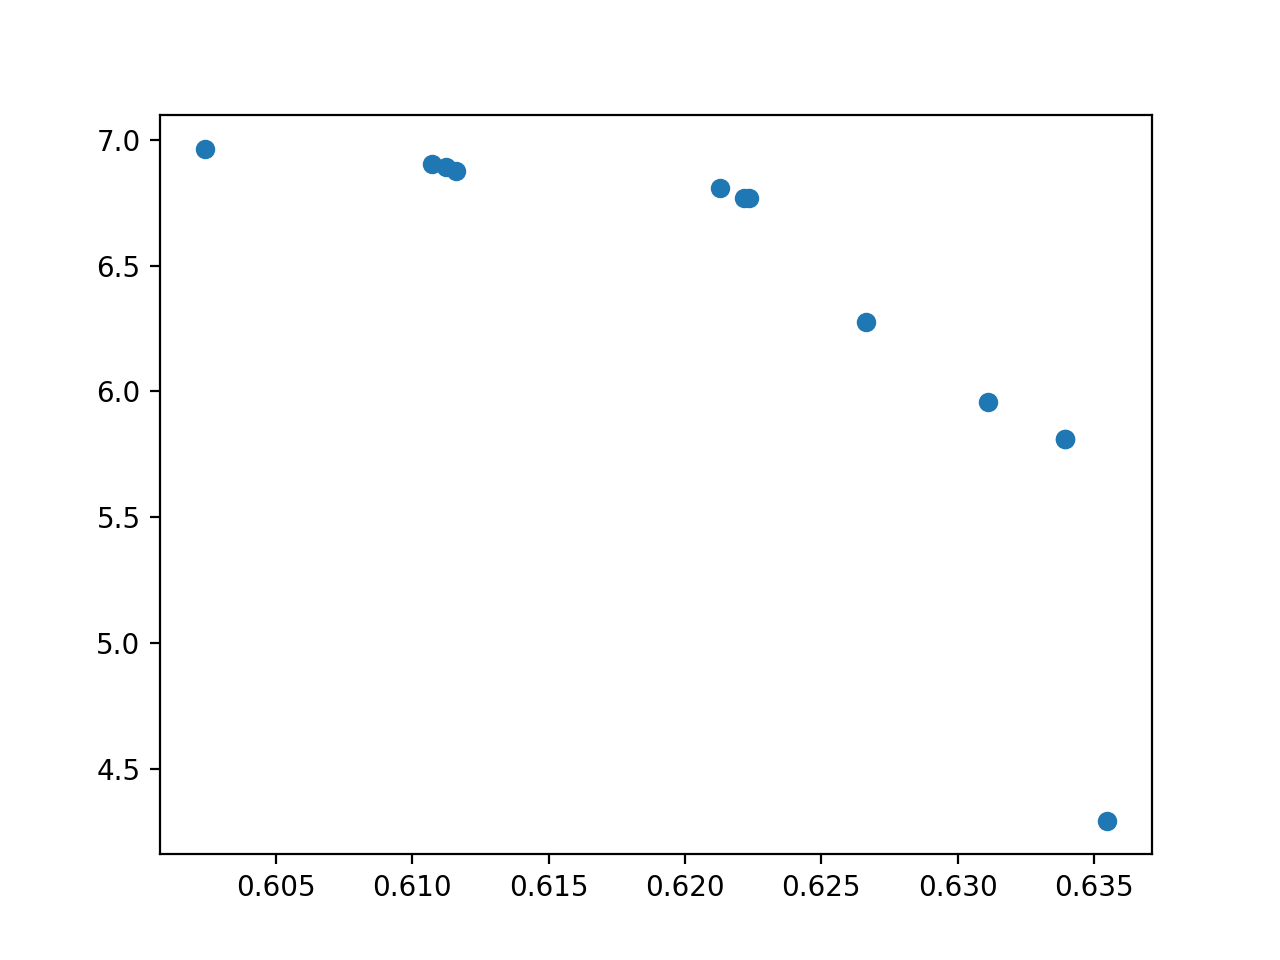

In [19]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.plot([x[0] for x in hey.values()],[abs(x[1]) for x in hey.values()],"o")
plt.show()


In [134]:
def final_df():
    global hf
    funds = hf.columns
    df = pd.read_csv("Discount_fixed_income_HY.csv", index_col=0)
    my_dir = os.listdir("./funds_fixed_income")
    my_dir.remove(".DS_Store")
    funds = list(map(lambda x: x.split(".")[0].upper(), my_dir))
    df = df[df.index.isin(funds)]
    df = df.iloc[:,-3:len(hf.columns)-1]
    #print(list(filter(lambda x: x not in list(df.index), funds)))
    df.columns = ["Discount", "52W Discount", "Effective"]
    df["Discount"] = list(map(lambda x: str(x).strip("%"), list(df["Discount"])))
    df["Effective"] = [0 if x=="--" else str(x).strip('%') for x in list(df["52W Discount"])]
    df["52W Discount"] = [0 if x=="--" else str(x).strip('%') for x in list(df["Effective"])]
    df = df.astype('float')
    return df


df = final_df()
i = final.iloc[final.index.get_level_values(0) == -8]
#list(filter(lambda x: x not in list(i.index.get_level_values(1)), df.index))
i.index = i.index.get_level_values(1)
df = i.merge(df, how="outer", right_index=True, left_index=True).fillna(0)

df = df.sort_values(by=["Weights"], ascending=False)

,Weights,Discount,52W Discount,Effective
HYB,0.34790,-12.02,-11.92,-11.92
ISD,0.26790,-10.31,-11.98,-11.98
FSD,0.11684,-10.62,-11.21,-11.21
EAD,0.11469,-9.36,-10.99,-10.99
DHF,0.07109,-9.51,-11.01,-11.01
AIF,0.03290,-12.82,-14.04,-14.04
VLT,0.00837,-9.81,-11.23,-11.23
HIO,0.00823,-8.39,-9.03,-9.03
EIC,0.00790,-16.69,-23.92,-23.92
MPV,0.00757,-8.52,-3.15,-3.15
